<a href="https://colab.research.google.com/github/hyunseoki/GAN/blob/main/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import torch
import torch.nn as nn

from torchvision import datasets
import torchvision.transforms as transforms
# from torchvision.utils import save_image
from torchvision.transforms.functional import to_pil_image

import matplotlib.pyplot as plt
import time

In [47]:
class Config:
    latent_dim = 100
    lr = 1e-4
    batch_size = 128
    num_epochs = 200
    sample_interval = 2000

transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=4)

In [35]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_cls=10):
        super().__init__()
        
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                layers.append(nn.BatchNorm1d(output_dim))
            layers.append(nn.LeakyReLU(negative_slope=0.2))
            return layers
        
        self.label_emb = nn.Embedding(num_cls, num_cls)
        '''
            https://wikidocs.net/64779
            noise와 label을 결합할 용도인 embedding layer 생성
            embedding layer는 룩업 테이블 역할
            -> 입력텐서는 임베딩 벡터를 추출할 범주의 인덱스이므로 무조건 정수타입(LongTensor)이 들어가야된다.
            -> ex) forward 메소드에 (4,) 크기의 텐서가 입력으로 들어가면 (4,10) 크기의 텐서가 출력
        '''

        self.gen = nn.Sequential(
            *block(input_dim=latent_dim + num_cls,
                   output_dim=128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1*28*28),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        emb = self.label_emb(labels)
        gen_input = torch.cat((emb, noise),-1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), 1, 28, 28)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_cls=10):
        super().__init__()

        self.label_embedding = nn.Embedding(num_cls, num_cls)

        self.dis = nn.Sequential(
            nn.Linear(num_cls + 1 * 28 *28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img, labels):
        emb = self.label_embedding(labels)
        dis_input = torch.cat((img.view(img.size(0),-1), emb), -1)
        x = self.dis(dis_input)

        return x

In [41]:
generator = Generator(latent_dim=100)
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=Config.lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=Config.lr, betas=(0.5, 0.999))

loss_history={'gen':[],
              'dis':[]}

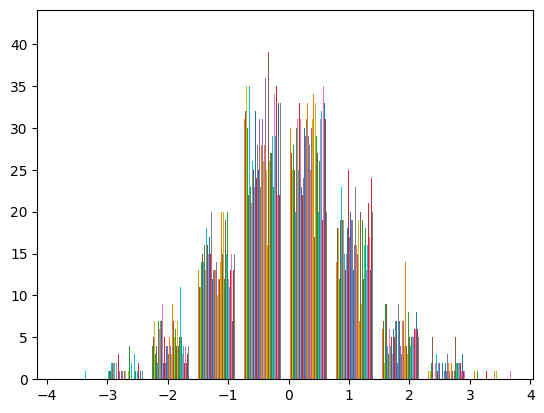

In [40]:
z = torch.normal(mean=0, std=1, size=(Config.batch_size, Config.latent_dim))
plt.hist(z)
plt.show()

In [48]:
start_time = time.time()

for epoch in range(Config.num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.cuda()
        real_labels = labels.cuda()

        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0
        

        ''' Generator ''' 
        optimizer_G.zero_grad()      

        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], Config.latent_dim)).cuda()
        fake_labels = torch.randint(0,10, (imgs.shape[0],)).cuda() # label 생성
        generated_imgs = generator(z, fake_labels)

        g_loss = adversarial_loss(discriminator(generated_imgs, fake_labels), real)
        g_loss.backward()
        optimizer_G.step()

        ''' Discriminator ''' 
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, real_labels), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach(), fake_labels), fake)
        d_loss = real_loss + fake_loss

        d_loss.backward()
        optimizer_D.step()

        loss_history['gen'].append(g_loss.item())
        loss_history['dis'].append(d_loss.item())

    print(f"[Epoch {epoch}/{Config.num_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 1.197452] [G loss: 0.838175] [Elapsed time: 18.98s]
[Epoch 1/200] [D loss: 1.126620] [G loss: 0.853782] [Elapsed time: 40.49s]
[Epoch 2/200] [D loss: 1.108954] [G loss: 1.134600] [Elapsed time: 61.10s]
[Epoch 3/200] [D loss: 1.117384] [G loss: 1.011372] [Elapsed time: 78.33s]
[Epoch 4/200] [D loss: 1.294205] [G loss: 0.524076] [Elapsed time: 95.31s]
[Epoch 5/200] [D loss: 1.187153] [G loss: 1.284833] [Elapsed time: 113.30s]
[Epoch 6/200] [D loss: 1.039670] [G loss: 1.024761] [Elapsed time: 130.71s]
[Epoch 7/200] [D loss: 1.036545] [G loss: 0.886958] [Elapsed time: 147.62s]
[Epoch 8/200] [D loss: 1.151527] [G loss: 0.644765] [Elapsed time: 165.26s]
[Epoch 9/200] [D loss: 1.061610] [G loss: 0.830676] [Elapsed time: 182.64s]
[Epoch 10/200] [D loss: 0.914661] [G loss: 1.499664] [Elapsed time: 199.98s]
[Epoch 11/200] [D loss: 1.069023] [G loss: 1.013787] [Elapsed time: 217.65s]
[Epoch 12/200] [D loss: 1.155968] [G loss: 0.748768] [Elapsed time: 234.69s]
[Epoch 13/200]

KeyboardInterrupt: ignored

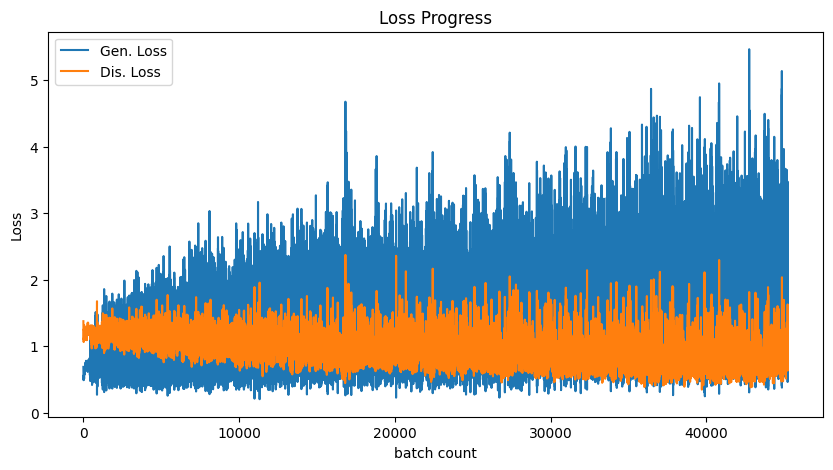

In [50]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
generator.eval()

# fake image 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100).cuda()
    label = torch.randint(0,10,(16,)).cuda()
    img_fake = generator(fixed_noise, label).detach().cpu()

print(img_fake.shape)

torch.Size([16, 1, 28, 28])


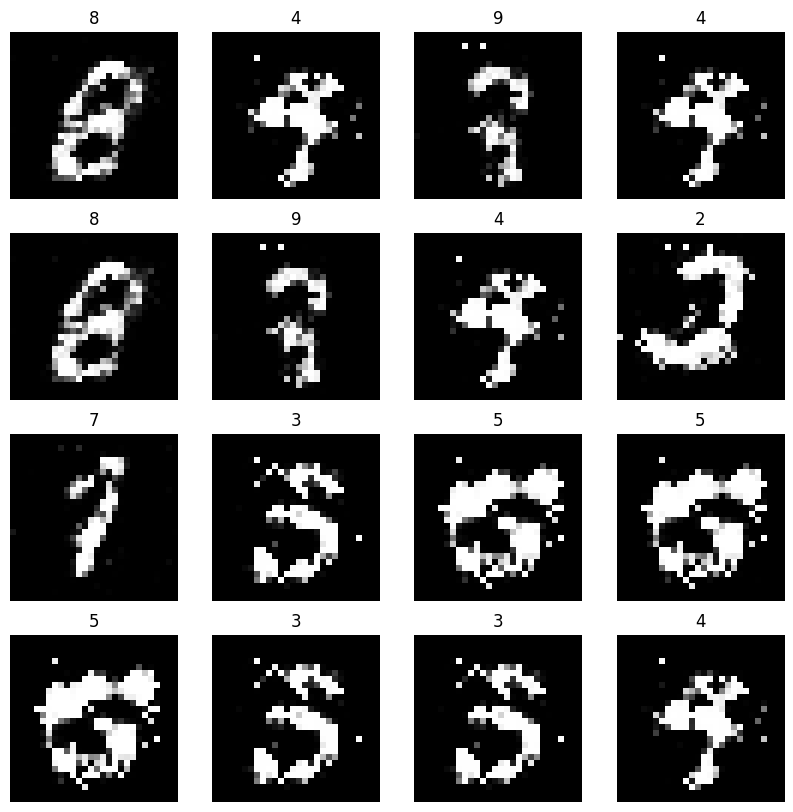

In [52]:
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.title(label[ii].item())
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5), cmap='gray')
    plt.axis('off')